In [1]:
data_root = '/kaggle/input/child-mind-institute-detect-sleep-states'

#### Colab setup

In [2]:
colab = False

In [3]:
def download_data():
  !mkdir -p ~/.kaggle
  !wget -O ~/.kaggle/kaggle.json "https://drive.google.com/uc?export=download&id=1eN1kfpt1EQS-KQk-A9M2hWO-uhEBMwE0"
  !chmod 600 ~/.kaggle/kaggle.json

  !kaggle competitions download 'child-mind-institute-detect-sleep-states'
  !mkdir -p data
  !unzip -qqn child-mind-institute-detect-sleep-states.zip -d data

if colab:
  download_data()
  data_root = 'data'

### Imports

- os: to handle file system paths
- gc: garbage collector to free up space mid-run
- pyarrow: parquet reading
- pandas: data analysis
- numpy: calculations

In [4]:
from os import path
import gc
import pyarrow as pa
import pyarrow.parquet
import pandas as pd
import numpy as np

data_root: the path to the directory containing the train and test data

### Importing the training events

train_events: contains the data from train_events.csv, this includes:
- **series_id (str)**: id of a series corresponding to a person's readings
- **night (int)**: nth night in a given series
- **event (str)**: either onset or wakeup
- **step (int)**: there is 1 reading in the train_series every 5 seconds, 1 step is this interval

series_list: all the unique series_ids in one list

In [5]:
train_events = pd.read_csv(
    path.join(data_root, 'train_events.csv'),
    dtype={
        'series_id': 'str',
        'night': 'Int32',
        'event': 'str',
        'step': 'Int64',
    }
)
series_list = train_events['series_id'].unique()
print(series_list[:10])
print(len(series_list))

['038441c925bb' '03d92c9f6f8a' '0402a003dae9' '04f547b8017d'
 '05e1944c3818' '062cae666e2a' '062dbd4c95e6' '08db4255286f'
 '0a96f4993bd7' '0cd1e3d0ed95']
277


### Preprocessing the training events

Drop events without time information. We do this because an **event without time information means there was no sleep recorded** for the given night.

In [6]:
train_events = train_events.dropna(axis=0)
train_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9585 entries, 0 to 14505
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   series_id  9585 non-null   object
 1   night      9585 non-null   Int32 
 2   event      9585 non-null   object
 3   step       9585 non-null   Int64 
 4   timestamp  9585 non-null   object
dtypes: Int32(1), Int64(1), object(3)
memory usage: 430.6+ KB


#### Filter out invalid nights

An invalid night is a night where either the **onset or wakeup time is missing**.

In [7]:
bad_nights = train_events[['series_id', 'night', 'event']].groupby(by=['series_id', 'night']).count()
bad_nights = bad_nights[bad_nights['event']!=2].reset_index()
print(bad_nights)

      series_id  night  event
0  0ce74d6d2106     20      1
1  154fe824ed87     30      1
2  44a41bba1ee7     10      1
3  efbfc4526d58      7      1
4  f8a8da8bdd00     17      1


In [8]:
bad_series = bad_nights['series_id'].unique()

In [9]:
print(bad_series)

['0ce74d6d2106' '154fe824ed87' '44a41bba1ee7' 'efbfc4526d58'
 'f8a8da8bdd00']


In [10]:
train_events = train_events[~(train_events['series_id'].isin(bad_series))]

In [11]:
series_list = train_events['series_id'].unique()
print(series_list[:10])
print(len(series_list))

['038441c925bb' '03d92c9f6f8a' '0402a003dae9' '04f547b8017d'
 '05e1944c3818' '062cae666e2a' '062dbd4c95e6' '08db4255286f'
 '0a96f4993bd7' '0cd1e3d0ed95']
264


### Importing the training time series

train_series: contains the data from train_series.parquet, this includes:
- **series_id (str)**: id of a series corresponding to a person's readings
- **anglez (float)**: z-angle is a metric that refers to the angle of the arm relative to the vertical axis of the body
- **enmo (float)**: Euclidean Norm Minus One of all accelerometer signals, with negative values rounded to zero

not included:
- **step (int)**: there is 1 reading in the train_series every 5 seconds, 1 step is this interval
- **timestamp (timestamp)**: the time of the reading
we do not need time information as there is no causation between sleep state changes and time

In [12]:
train_series = pd.read_parquet(path.join(data_root, 'train_series.parquet'), columns=['series_id', 'anglez', 'enmo'])

### Standardization

Using the **StandardScaler** from sklearn.preprocessing we can easily standardize our dataset to have the properties:
- mean = 0
- std = 1

In [14]:
from sklearn.preprocessing import StandardScaler
input_scaler = StandardScaler()
input_scaler.fit(train_series[['anglez', 'enmo']])
train_series[['anglez', 'enmo']] = input_scaler.transform(train_series[['anglez', 'enmo']])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_ex

In [16]:
event_map = {}
for series_id, events in train_events.groupby('series_id'):
    event_map[series_id] = events.drop(columns=['series_id', 'timestamp']).reset_index(drop=True)

In [17]:
series_map = {}
for series_id, series in train_series.groupby('series_id'):
    series_map[series_id] = series[['enmo', 'anglez']].to_numpy()

### Splitting training and test series

In [18]:
train_series_ids = set(series_list)

In [19]:
train_series = None
gc.collect()

0

### Sampling data

In [20]:
import random
import matplotlib.pyplot as plt

In [27]:
FRAME_SIZE = 60 * 12 # frame width
MIN_NONE_SAMPLE_INTERVAL = 4 * 60 * 12 # minimum steps between events to sample none frames from
NONE_PADDING = 30 * 12 # padding between events and none frames
EVENT_SAMPLE_MARGIN = 15 * 12 # event margin to frame edges
EVENT_SAMPLE_STRIDE = 3 * 12 # event sampling stride

In [28]:
# Extracts samples between two events
def sample_between(start, end, n_samples, padding=NONE_PADDING) -> list[tuple[int]]:
    samples = []
    gap = (end - start - 2 * padding - n_samples * FRAME_SIZE) // (n_samples - 1)
    stride = gap + FRAME_SIZE
    for frame_start in range(start + padding, end - FRAME_SIZE - padding + 1, stride):
        samples.append((frame_start, frame_start+FRAME_SIZE))
    return samples

In [29]:
# Extracts samples around an event
def sample_around(event, margin, stride) -> list[list]:
    samples = []
    for frame_start in range(event - FRAME_SIZE + margin + 1, event - margin + 1, stride):
        samples.append((frame_start, frame_start + FRAME_SIZE))
    return samples

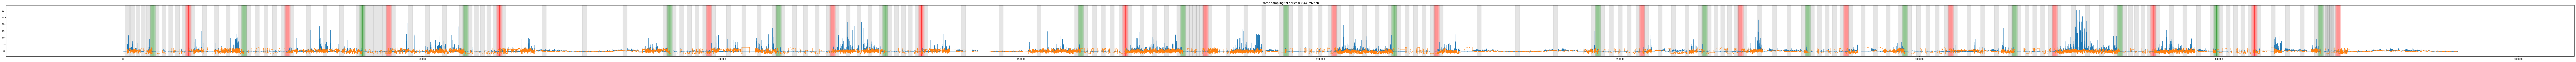

In [30]:
def display_sampling(series_id):
    series = series_map[series_id]
    events = event_map[series_id]
    plt.figure(figsize=(200, 4))
    plt.title(f'Frame sampling for series {series_id}')

    last_event_step = 0
    for i in range(len(events)):
        step = events['step'][i]
        type = events['event'][i]

        event_color = 'green' if type == 'onset' else 'red'
        plt.axvline(step, color=event_color, lw=0.5)

        event_samples = sample_around(step, EVENT_SAMPLE_MARGIN, EVENT_SAMPLE_STRIDE)
        for frame_start, frame_end in event_samples:
            plt.axvspan(frame_start, frame_end, color=event_color, alpha=0.05)

        if step - last_event_step >= MIN_NONE_SAMPLE_INTERVAL:
            n_samples = len(event_samples) // 2
            for frame_start, frame_end in sample_between(last_event_step, step, n_samples):
                plt.axvspan(frame_start, frame_end, color='black', alpha=0.1)
        last_event_step = step
    plt.plot(series, lw=0.5)

display_sampling(series_list[0])

In [31]:
X_none = []
X_onset = []
X_onset_time = []
X_wakeup = []
X_wakeup_time = []
for series_id in train_series_ids:
    series = series_map[series_id]
    events = event_map[series_id]

    last_event_step = 0
    for i in range(len(events)):
        step = events['step'][i]
        type = events['event'][i]

        event_samples = sample_around(step, EVENT_SAMPLE_MARGIN, EVENT_SAMPLE_STRIDE)
        for frame_start, frame_end in event_samples:
            if frame_start < 0 or frame_end >= series.shape[0]:
                continue
            if type == 'onset':
                X_onset.append(series[frame_start:frame_end])
                X_onset_time.append(step - frame_start)
            if type == 'wakeup':
                X_wakeup.append(series[frame_start:frame_end])
                X_wakeup_time.append(step - frame_start)
        if step - last_event_step >= MIN_NONE_SAMPLE_INTERVAL:
            n_samples = len(event_samples) // 2
            for frame_start, frame_end in sample_between(last_event_step, step, n_samples):
                if frame_start < 0 or frame_end >= series.shape[0]:
                    continue
                X_none.append(series[frame_start:frame_end])
        last_event_step = step

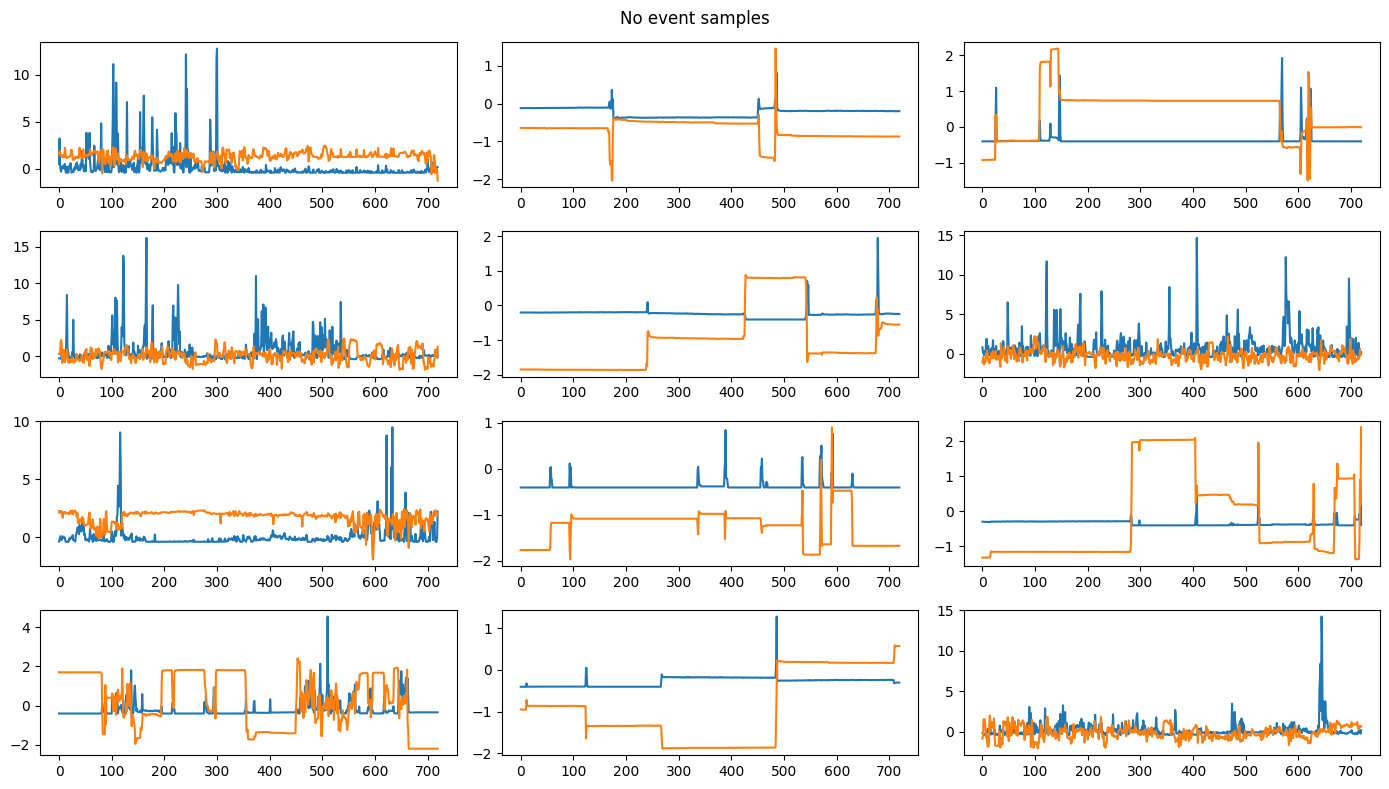

In [32]:
def plot_none_samples(samples):
    cols = 3
    rows = 4
    fig, ax = plt.subplots(rows, cols, figsize=(14, 8))
    for i in range(rows):
        for j in range(cols):
            ax[i][j].plot(samples[j * rows + i])
    plt.suptitle('No event samples')
    plt.tight_layout()
    plt.show()

plot_none_samples(random.sample(X_none, 12))

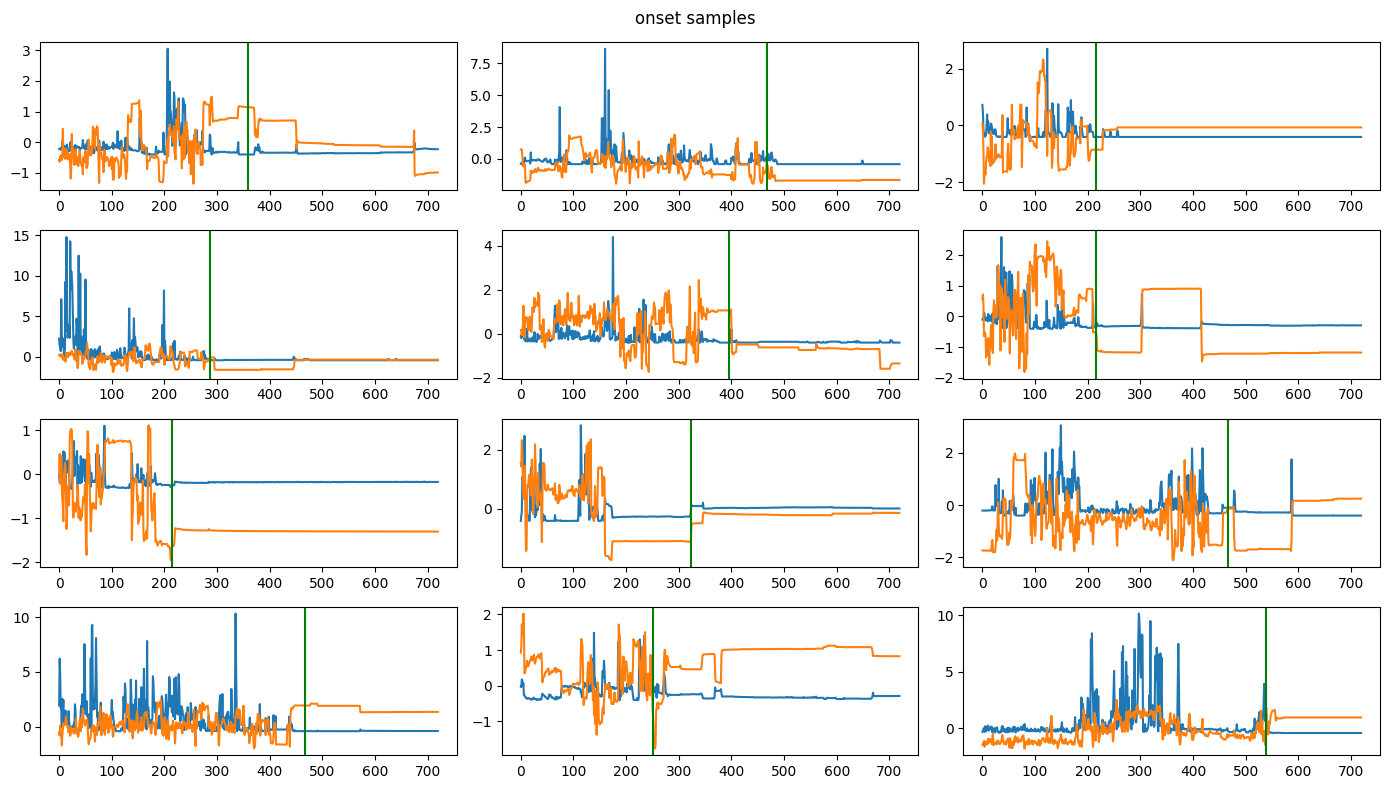

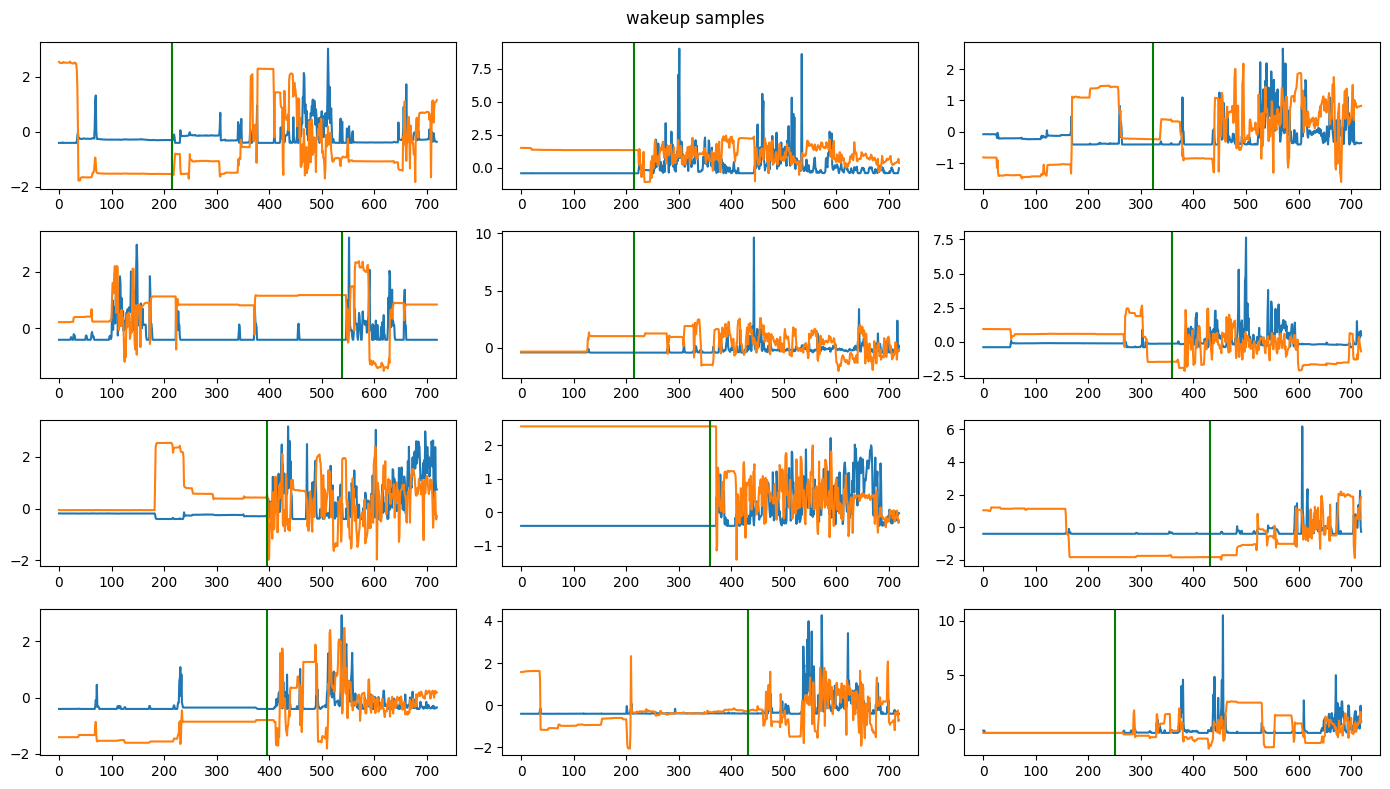

In [33]:
def plot_event_samples(type, samples: list[tuple]):
    cols = 3
    rows = 4
    _, ax = plt.subplots(rows, cols, figsize=(14, 8))
    for i in range(rows):
        for j in range(cols):
            sample = samples[j * rows + i]
            ax[i][j].plot(sample[0])
            ax[i][j].axvline(sample[1], c='green')
    plt.suptitle(f'{type} samples')
    plt.tight_layout()
    plt.show()

plot_event_samples('onset', random.sample(list(zip(X_onset, X_onset_time)), 12))
plot_event_samples('wakeup', random.sample(list(zip(X_wakeup, X_wakeup_time)), 12))

### Assembling the dataset

In [34]:
n_features = 2

In [35]:
n_samples = len(X_none) + len(X_onset) + len(X_wakeup)

X = np.empty([n_samples, FRAME_SIZE, n_features], dtype=np.float32) # input
Y = np.zeros([n_samples, 3], dtype=np.float32) # labels

idx = 0
def fill_data(x, y_idx):
    global idx
    n = len(x)
    X[idx:idx + n] = x
    Y[idx:idx + n, y_idx] = 1.0
    idx += n

fill_data(X_none, 0)
fill_data(X_onset, 1)
fill_data(X_wakeup, 2)

In [36]:
print(X.shape)
print(Y.shape)

(140247, 720, 2)
(140247, 3)


In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)
print(len(X_train), len(Y_train))
print(len(X_test), len(Y_test))

119209 119209
21038 21038


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the model
model = Sequential()
model.add(Conv1D(128, 4, activation='relu', input_shape=(FRAME_SIZE, n_features)))
model.add(MaxPooling1D(4))
model.add(Conv1D(64, 4, activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint("model.hdf5", save_best_only=True)
network_history = model.fit(X_train, Y_train, epochs=5, validation_split=0.15, batch_size=64, verbose=1, callbacks=[early_stopping, model_checkpoint])

Epoch 1/5
1584/1584 [==============================] - 21s 7ms/step - loss: 0.2780 - accuracy: 0.9111 - val_loss: 0.2122 - val_accuracy: 0.9305
Epoch 2/5
  10/1584 [..............................] - ETA: 9s - loss: 0.2283 - accuracy: 0.9219 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1584/1584 [==============================] - 10s 6ms/step - loss: 0.2290 - accuracy: 0.9281 - val_loss: 0.2065 - val_accuracy: 0.9341
Epoch 3/5
1584/1584 [==============================] - 10s 7ms/step - loss: 0.2146 - accuracy: 0.9330 - val_loss: 0.1988 - val_accuracy: 0.9343
Epoch 4/5
1584/1584 [==============================] - 10s 6ms/step - loss: 0.1993 - accuracy: 0.9365 - val_loss: 0.2046 - val_accuracy: 0.9318
Epoch 5/5
1584/1584 [==============================] - 10s 6ms/step - loss: 0.1870 - accuracy: 0.9406 - val_loss: 0.2100 - val_accuracy: 0.9314


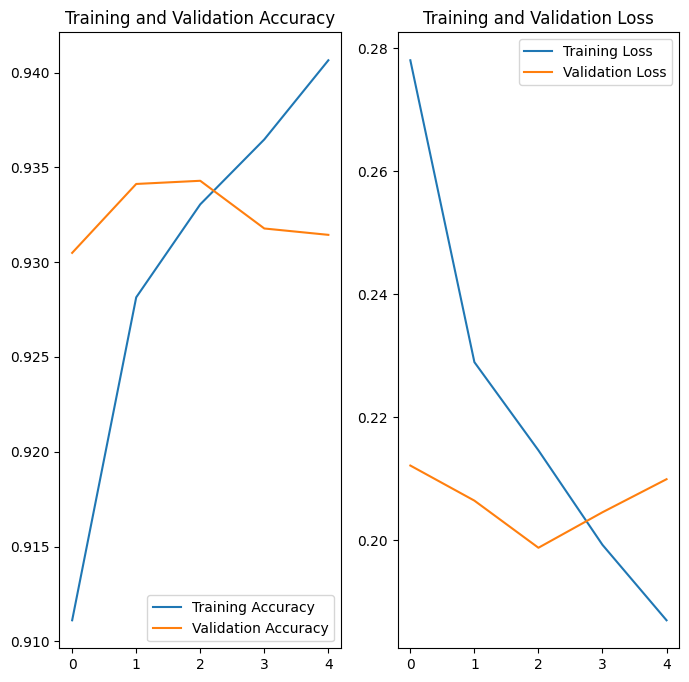

In [41]:
acc = network_history.history['accuracy']
val_acc = network_history.history['val_accuracy']

loss = network_history.history['loss']
val_loss = network_history.history['val_loss']

epochs_range = range(len(network_history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
from keras.models import load_model
model = load_model("model.hdf5")
test_err = model.evaluate(X_test,Y_test)
print(f"Test loss: {test_err[0]:.2}, Test accuracy: {test_err[1]:.2%}")

output = ['none', 'onset', 'wakeup']
print(output[np.argmax(model.predict(X[1].reshape(1, -1 , 2)))])
print(output[np.argmax(model.predict(X[len(X)//2].reshape(1, -1 , 2)))])
print(output[np.argmax(model.predict(X[-1].reshape(1, -1 , 2)))])

658/658 [==============================] - 2s 3ms/step - loss: 0.2026 - accuracy: 0.9335
Test loss: 0.2, Test accuracy: 93.35%
1/1 [==============================] - 0s 109ms/step
onset
1/1 [==============================] - 0s 23ms/step
onset
1/1 [==============================] - 0s 23ms/step
wakeup


### Prediction

In [43]:
PRED_STRIDE = 5 * 12
PRED_PROBABILITY_THRESHOLD = 0.95
PRED_MERGE_THRESHOLD = 20 * 12
MIDNIGHT_POINT = 2160

In [44]:
EVT_ONSET = 1
EVT_WAKEUP = 2

In [45]:
def get_rolling_frames(series):
    n_frames = (series.shape[0] - FRAME_SIZE) // PRED_STRIDE + 1
    centers = np.empty([n_frames])
    frames = np.empty([n_frames, FRAME_SIZE, n_features])
    for idx, frame_start in enumerate(range(0, series.shape[0] - FRAME_SIZE + 1, PRED_STRIDE)):
        frames[idx] = series[frame_start:frame_start + FRAME_SIZE]
        centers[idx] = frame_start + FRAME_SIZE // 2
    return frames, centers

In [46]:
def get_predicted_events(predictions, frame_centers, event_idx):
    predicted_events = []
    for idx, pred in enumerate(predictions):
        p = pred[event_idx] # predicted probability of event
        if p >= PRED_PROBABILITY_THRESHOLD:
            predicted_events.append(frame_centers[idx])
    return predicted_events

In [47]:
def combine_predictions(predictions):
    combined = []
    segment = []
    last = None
    for step in predictions:
        if last != None and step - last > PRED_MERGE_THRESHOLD:
            points = np.array(segment)
            combined.append(points.mean())
            segment.clear()
        segment.append(step)
        last = step
    return combined

In [48]:
def merge_events(onsets, wakeups):
    merged_events = []
    merged_events.extend([(EVT_ONSET, step) for step in onsets])
    merged_events.extend([(EVT_WAKEUP, step) for step in wakeups])
    merged_events.sort(key=lambda event: event[1])
    return merged_events

In [49]:
def fit_sleep_periods(events):
    sleeps = []

    sleep_start = None
    sleep_end = None

    for event, step in events:
        if event == EVT_WAKEUP and sleep_start == None:
            continue
        if event == EVT_ONSET and sleep_start == None:
            sleep_start = step
        if event == EVT_WAKEUP and sleep_start != None:
            sleep_end = step
        if event == EVT_ONSET and sleep_end != None:
            sleeps.append((sleep_start, sleep_end))
            sleep_start = step
            sleep_end = None

    return sleeps

In [77]:
def assign_to_nights(series_len, start_time, sleep_periods):
    n_nights = (series_len + start_time - MIDNIGHT_POINT) // (24 * 60 * 12) + 1
    sleeps_per_night = [[] for _ in range(0, n_nights)]
    for start, end in sleep_periods:
        mid = int((start + end) / 2)
        night_idx = (mid + start_time - MIDNIGHT_POINT + 12 * 60 * 12) // (24 * 60 * 12)
        sleeps_per_night[night_idx].append((start, end))
    return sleeps_per_night

In [78]:
def filter_max_sleeps(sleeps_nights):
    return [ max(sleeps, key=lambda sleep: sleep[1] - sleep[0]) for sleeps in sleeps_nights if sleeps != []]

In [79]:
def predict_sleep_periods(series: np.ndarray, start_time) -> list[tuple[int]]:
    prediction_frames, centers = get_rolling_frames(series)
    predictions = model.predict(prediction_frames)

    onsets_predicted = get_predicted_events(predictions, centers, EVT_ONSET)
    wakeups_predicted = get_predicted_events(predictions, centers, EVT_WAKEUP)

    onsets_predicted = combine_predictions(onsets_predicted)
    wakeups_predicted = combine_predictions(wakeups_predicted)

    sleeps_predicted = fit_sleep_periods(merge_events(onsets_predicted, wakeups_predicted))
    sleeps_filtered = filter_max_sleeps(assign_to_nights(len(series), start_time, sleeps_predicted))
    return sleeps_filtered

In [80]:
def create_submission_df(series_id, sleeps):
    submission = None
    for onset, wakeup in sleeps:
        sleep_df = pd.DataFrame([
            {'series_id': series_id, 'step': onset, 'event': 'onset', 'score': 0.5},
            {'series_id': series_id, 'step': wakeup, 'event': 'wakeup', 'score': 0.5}
        ])
        if submission is None:
            submission = sleep_df
        else:
            submission = pd.concat([submission, sleep_df], ignore_index=True)
    return submission

### Reading test series

In [81]:
X_none = None
X_train = None
X_wakeup = None
X_onset = None
gc.collect()

78883

In [62]:
from datetime import datetime

In [74]:
test_series = pd.read_parquet(path.join(data_root, 'test_series.parquet'), columns=['series_id', 'timestamp', 'anglez', 'enmo'])
test_series[['anglez', 'enmo']] = input_scaler.transform(test_series[['anglez', 'enmo']])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [75]:
submission = None
for series_id, s in test_series.groupby('series_id'):
    series = s.reset_index(drop=True)
    if (len(series) < FRAME_SIZE):
        continue
    first_timestamp = series['timestamp'][0]
    first_timestamp = datetime.strptime(first_timestamp[:-5], '%Y-%m-%dT%H:%M:%S')
    first_step_time = (first_timestamp.hour * 3600 + first_timestamp.minute * 60 + first_timestamp.second) // 5
    series_data = series[['enmo', 'anglez']].reset_index(drop=True).to_numpy()
    sleeps = predict_sleep_periods(series_data, first_step_time)
    sleeps_df = create_submission_df(series_id, sleeps)
    if submission is None:
        submission = sleeps_df
    else:
        submission = pd.concat([submission, sleeps_df], ignore_index=True)

In [76]:
if submission is not None:
    submission.to_csv('submission.csv', index_label='row_id')
